In [1]:
import pandas as pd
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import numpy as np

- Indentify the top 10 retrievable CORUM complexes based on their size.
- Plot all the replicable profiles from these complexes.
- Size of the data points should be proportional to the replicate retrieval mAP score.

In [2]:
label_count = 15
member_count_threshold = 5
label_retrieval_threshold = 0.1

filename = "corum_complex"
label_column_name = "Metadata_corum_complex_list"
metadata_column_name = "Metadata_complexname"

# filename = "wikipathway"
# label_column_name = "Metadata_wikipathway_list"
# metadata_column_name = "Metadata_wikipathway"

In [3]:
# Read profiles

orf_profiles_df = pd.read_parquet(
    "../profiles/profiles_wellpos_cc_var_mad_outlier_featselect_sphering_harmony.parquet"
)

orf_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,X_1,X_2,X_3,X_4,X_5,X_6,...,X_713,X_714,X_715,X_716,X_717,X_718,X_719,X_720,X_721,X_722
0,source_4,BR00117035,A01,JCP2022_905588,0.052849,0.243130,-0.025814,1.463608,0.118261,0.768867,...,0.007945,0.231715,-0.439640,-0.272064,-0.326058,-0.315760,1.113890,2.681547,0.556489,-1.012824
1,source_4,BR00117035,K16,JCP2022_904671,0.291435,0.856620,-0.087470,0.829247,-0.260318,0.096628,...,0.041054,0.183351,-0.082316,-0.021600,-0.314601,-0.093980,-0.768527,0.122399,-0.206554,-0.124473
2,source_4,BR00117035,K15,JCP2022_910002,1.051215,0.050609,0.055375,-0.892842,-0.293192,0.241954,...,0.817725,-0.560760,-0.493579,-0.743412,-0.308875,-0.698211,0.117192,0.416552,-0.220121,0.597348
3,source_4,BR00117035,K14,JCP2022_915130,-0.926487,0.877830,-0.176330,0.490574,-0.092425,0.312627,...,0.156092,-0.090704,-0.229331,0.215088,-0.142982,0.212413,-0.570515,-0.104503,-0.228382,0.419602
4,source_4,BR00117035,K13,JCP2022_907169,-0.454818,0.058401,0.453824,-0.760628,-0.782859,0.467273,...,0.623233,-0.210110,-0.600980,-0.397738,-0.594362,-0.354290,-0.155720,0.191323,0.011434,-0.229435


In [4]:
# Read label retrieval scores

label_df = (
    pd.read_parquet(
        f"../03.retrieve-annotations/output/{filename}_retrieval.parquet",
        columns=[
            f"{label_column_name}",
            "mean_average_precision",
            "below_corrected_p",
            "Modality",
        ],
    )
    .query("Modality=='ORF'")
    .query("below_corrected_p==True")
    .drop(columns=["Modality", "below_corrected_p"])
    .rename(
        columns={"mean_average_precision": f"{filename}_retrieval_mean_average_precision"}
    )
)
label_df.head()

,Metadata_corum_complex_list,corum_complex_retrieval_mean_average_precision
8,"39S ribosomal subunit, mitochondrial",0.068602
9,"40S ribosomal subunit, cytoplasmic",0.093806
11,"55S ribosome, mitochondrial",0.102406
40,AIM2 PANoptosome complex,0.313672
55,ALL-1 supercomplex,0.060965


In [5]:
# Read phenotypic activity scores

phenotypic_activity_df = (
    pd.read_csv(
        "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony.csv.gz",
        usecols=[
            "Metadata_JCP2022",
            "mean_average_precision",
            "below_corrected_p",
        ],
    )
    .query("below_corrected_p==True")
    .drop(columns=["below_corrected_p"])
    .rename(
        columns={
            "mean_average_precision": "phenotypic_activity_mean_average_precision",
        }
    )
)
phenotypic_activity_df.head()

,Metadata_JCP2022,phenotypic_activity_mean_average_precision
1,JCP2022_900003,0.746396
2,JCP2022_900004,0.977500
3,JCP2022_900005,1.000000
4,JCP2022_900006,0.700833
6,JCP2022_900009,0.746851


In [6]:
# Add ORF annotations

orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep='\t',
    usecols=["Metadata_JCP2022", "Metadata_Symbol", f"{metadata_column_name}"],
)

orf_metadata_df.head()

,Metadata_JCP2022,Metadata_Symbol,Metadata_complexname
0,JCP2022_900001,NaN,NaN
1,JCP2022_900002,NAT1,NaN
2,JCP2022_900003,AANAT,NaN
3,JCP2022_900004,ABAT,NaN
4,JCP2022_900005,ACADVL,NaN


In [7]:
orf_metadata_df = (
    orf_metadata_df.assign(
    col=orf_metadata_df[f"{metadata_column_name}"].str.split("|")
)
.explode("col")
.rename(columns={"col": f"{label_column_name}"})
.drop(columns=[f"{metadata_column_name}"])
)

In [8]:
# Merging all the dataframes

orf_profiles_df = (
    orf_profiles_df.merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .merge(phenotypic_activity_df, on="Metadata_JCP2022", how="inner")
    .merge(label_df, on=f"{label_column_name}", how="inner")
)

orf_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,X_1,X_2,X_3,X_4,X_5,X_6,...,X_717,X_718,X_719,X_720,X_721,X_722,Metadata_Symbol,Metadata_corum_complex_list,phenotypic_activity_mean_average_precision,corum_complex_retrieval_mean_average_precision
0,source_4,BR00117035,K05,JCP2022_914715,-1.855125,0.763992,-0.646290,0.816239,0.363405,0.205804,...,-0.040452,0.062382,-0.024918,0.185916,-0.008217,-0.086762,MORF4L1,NuA4/Tip60-HAT complex,0.856905,0.114063
1,source_4,BR00117035,K05,JCP2022_914715,-1.855125,0.763992,-0.646290,0.816239,0.363405,0.205804,...,-0.040452,0.062382,-0.024918,0.185916,-0.008217,-0.086762,MORF4L1,NuA4/Tip60-HAT complex,0.856905,0.114063
2,source_4,BR00117036,K05,JCP2022_914715,-0.538906,-0.409528,-0.476183,0.686024,0.621258,-0.080974,...,0.033004,0.219225,0.085686,0.152183,-0.236291,-0.370015,MORF4L1,NuA4/Tip60-HAT complex,0.856905,0.114063
3,source_4,BR00117036,K05,JCP2022_914715,-0.538906,-0.409528,-0.476183,0.686024,0.621258,-0.080974,...,0.033004,0.219225,0.085686,0.152183,-0.236291,-0.370015,MORF4L1,NuA4/Tip60-HAT complex,0.856905,0.114063
4,source_4,BR00121558,K05,JCP2022_914715,-0.974321,-0.651234,-0.186865,0.935239,-0.135413,0.488035,...,0.764161,0.519380,0.251717,0.128188,-0.711404,-0.556406,MORF4L1,NuA4/Tip60-HAT complex,0.856905,0.114063


In [9]:
# Consensus profile

orf_profiles_df = utils.consensus(orf_profiles_df, "Metadata_Symbol")
orf_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_corum_complex_list,X_1,X_2,X_3,X_4,...,X_715,X_716,X_717,X_718,X_719,X_720,X_721,X_722,phenotypic_activity_mean_average_precision,corum_complex_retrieval_mean_average_precision
0,source_4,BR00117035,K05,JCP2022_914715,MORF4L1,NuA4/Tip60-HAT complex,-0.657268,-0.409528,-0.476183,0.686024,...,-0.456957,0.087171,0.033004,0.140478,0.085686,0.154489,-0.236291,-0.370015,0.856905,0.104344
1,source_4,BR00117035,E21,JCP2022_910775,RUVBL2,NuA4/Tip60-HAT complex,0.152668,-0.109330,0.221154,-0.156023,...,-0.378670,-0.022868,-0.147412,-0.107143,0.016821,0.123060,0.092916,0.248805,0.627473,0.104344
2,source_4,BR00121537,L21,JCP2022_901736,YEATS4,NuA4/Tip60-HAT complex,0.562274,-0.413378,-0.245493,-0.163381,...,-0.315987,-0.043726,-0.103067,0.041774,-0.254339,0.121019,0.063317,-0.220768,0.548632,0.114063
3,source_4,BR00121537,F23,JCP2022_901833,RUVBL1,NuA4/Tip60-HAT complex,1.217093,-1.062466,0.104053,0.603435,...,-0.207603,-0.544990,0.534887,-0.208252,-0.095640,0.015939,-0.519087,-0.032440,0.732976,0.094625
4,source_4,BR00121562,B18,JCP2022_903345,MRGBP,NuA4/Tip60-HAT complex,-0.148817,0.220399,-0.222637,0.252864,...,-0.051884,-0.233006,-0.045754,0.091244,-0.417479,-0.103818,-0.061121,0.086153,0.610920,0.114063


In [10]:
large_labels = (
    orf_profiles_df[f"{label_column_name}"]
    .value_counts()
    .reset_index()
    .query(f"{label_column_name} >= @member_count_threshold")["index"]
    .to_list()
)

selected_labels = (
    orf_profiles_df.query(f"{label_column_name} in @large_labels")
    .sort_values(by=f"{filename}_retrieval_mean_average_precision", ascending=False)
    .query(f"{filename}_retrieval_mean_average_precision >= @label_retrieval_threshold")
    .drop_duplicates(subset=[f"{label_column_name}"], keep="first")
    .nlargest(label_count, f"{filename}_retrieval_mean_average_precision")
)[f"{label_column_name}"].to_list()

In [11]:
orf_profiles_df = orf_profiles_df.query(f"{label_column_name} in @selected_labels")
orf_profiles_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Metadata_corum_complex_list,X_1,X_2,X_3,X_4,...,X_715,X_716,X_717,X_718,X_719,X_720,X_721,X_722,phenotypic_activity_mean_average_precision,corum_complex_retrieval_mean_average_precision
0,source_4,BR00117035,K05,JCP2022_914715,MORF4L1,NuA4/Tip60-HAT complex,-0.657268,-0.409528,-0.476183,0.686024,...,-0.456957,0.087171,0.033004,0.140478,0.085686,0.154489,-0.236291,-0.370015,0.856905,0.104344
1,source_4,BR00117035,E21,JCP2022_910775,RUVBL2,NuA4/Tip60-HAT complex,0.152668,-0.109330,0.221154,-0.156023,...,-0.378670,-0.022868,-0.147412,-0.107143,0.016821,0.123060,0.092916,0.248805,0.627473,0.104344
2,source_4,BR00121537,L21,JCP2022_901736,YEATS4,NuA4/Tip60-HAT complex,0.562274,-0.413378,-0.245493,-0.163381,...,-0.315987,-0.043726,-0.103067,0.041774,-0.254339,0.121019,0.063317,-0.220768,0.548632,0.114063
3,source_4,BR00121537,F23,JCP2022_901833,RUVBL1,NuA4/Tip60-HAT complex,1.217093,-1.062466,0.104053,0.603435,...,-0.207603,-0.544990,0.534887,-0.208252,-0.095640,0.015939,-0.519087,-0.032440,0.732976,0.094625
4,source_4,BR00121562,B18,JCP2022_903345,MRGBP,NuA4/Tip60-HAT complex,-0.148817,0.220399,-0.222637,0.252864,...,-0.051884,-0.233006,-0.045754,0.091244,-0.417479,-0.103818,-0.061121,0.086153,0.610920,0.114063


In [12]:
# Create umaps
X = utils.get_featuredata(orf_profiles_df)
orf_projection_2d = UMAP(n_components=2, random_state=12527).fit_transform(X)
orf_profiles_df["umap 1"] = orf_projection_2d[:, :1].flatten()
orf_profiles_df["umap 2"] = orf_projection_2d[:, 1:2].flatten()

# shuffle the data points
orf_profiles_df = orf_profiles_df.sample(frac=1, random_state=12527).reset_index(drop=True)

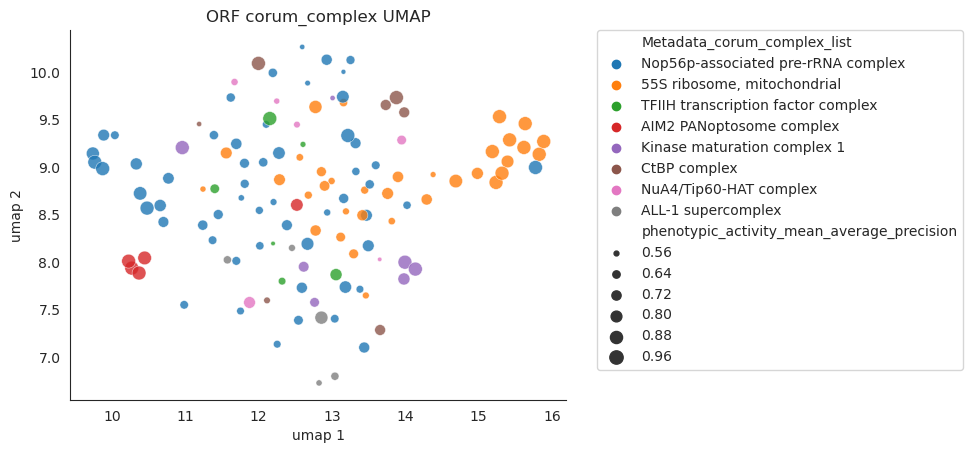

In [16]:
# Visualize UMAP

sns.set_style("white")

sns.scatterplot(
    data=orf_profiles_df,
    x="umap 1",
    y="umap 2",
    hue=f"{label_column_name}",
    size="phenotypic_activity_mean_average_precision",
    sizes=(10, 100),
    alpha=0.8,
).set_title(f"ORF {filename} UMAP")

sns.despine()
plt.legend(bbox_to_anchor=(1.8, 1), loc="upper right", borderaxespad=0, ncol=1)

plt.savefig(
    f"figures/orf_morphmap.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/orf_morphmap.svg", bbox_inches="tight", dpi=300
)